# Using APIs

Exam Topics Covered:
2.1 Implement robust REST API error handling for time outs and rate limits

2.2 Implement control flow of consumer code for unrecoverable REST API errors

2.3 Identify ways to optimize API usage through HTTP cache controls

2.4 Construct an application that consumes a REST API that supports pagination

2.5 Describe the steps in the OAuth2 three-legged authorization code grant flow

## Handling Timeouts

The code below implements a loop that will retry three times to connect to the site, and when the site fails to respond after 5 seconds a ReadTimeout exception will be thrown. Alternatively, the URL can be modified to a non-existent site and in this case a ConnectionError will be caught and the error displayed.

In [12]:
import requests

# Try to connect for up to 5 seconds, then retry up to 3 times
timeout = 5
attempts = 3

# This site can be used for testing, the delay/10 adds a 10 second delay to the response
url = 'https://httpbin.org/delay/10'
# Comment the above url and uncomment below to test the unavailable host functionality
#url = 'https://alkfjdsaofjasld.com'

for i in range(attempts):
    try:
        resp = requests.get(url, timeout=timeout)
    
    # If the request succeeded, then break out of loop
        if resp.ok:
            break
    # This is what happens if the site is valid but doesn't respond in a timely manner
    except requests.exceptions.ReadTimeout as err:
        if i + 1 == attempts:
            print(f'Retries exceeded, got error {err}')
            
    # This is what happens if the site is completely unreachable
    except requests.exceptions.ConnectionError as err:
        if i + 1 == attempts:
            print(f'Retries exceeded, got error {err}')
            
      

Retries exceeded, got error HTTPSConnectionPool(host='httpbin.org', port=443): Read timed out. (read timeout=5)


## Handling Rate Limits

API implementations often impose a rate limit on the number of requests in some way in order to prevent against oversubscription of resources.  This is often implemented as number of requests per minute.  For example, Cisco's public DNA Center sandbox for some calls only allows 5 requests per minute.  When the API limit is reached,  the server will return HTTP status `429 Too Many Requests`.

> Interestingly, the rate limiter may be applied to some endpoints but not others.  During writing of the below script, it was discovered that the rate limit does not apply to the /network-device API calls.  However,  it does apply to calls to /client-detail.  

In [18]:
import requests
from requests.auth import HTTPBasicAuth
import time
from pprint import pprint

username = "devnetuser"
password = "Cisco123!"
hostname = "sandboxdnac2.cisco.com"

headers = {"Content-Type": "application/json"}
# Use Basic Authentication
auth = HTTPBasicAuth(username, password)

# Request URL for the token
login_url = f"https://{hostname}/dna/system/api/v1/auth/token"

# Retrieve the token
resp = requests.post(login_url, headers=headers, auth=auth)
token = resp.json()['Token']

# Add the token to subsequent requests
headers['X-Auth-Token'] = token

url = f"https://{hostname}/dna/intent/api/v1/network-device"
resp = requests.get(url, headers=headers, auth=auth)

count = 0
# Loop over devices and get device by id
# Each time we reach five requests, pause for 60 seconds to avoid the rate limit
for i, device in enumerate(resp.json()['response']):
    count += 1
    device_count = len(resp.json()['response'])
    print (f"REQUEST #{i+1}")
    url = f"https://{hostname}/dna/intent/api/v1/network-device/{device['id']}"
    req = requests.get(url, headers=headers, auth=auth)
    pprint(req.json(), indent=2)
    if count == 5 and (i+1) < device_count:
        print("Sleeping for 60 seconds...")
        time.sleep(60)
        count = 0
    
    
        
    


REQUEST #1
{ 'response': { 'apManagerInterfaceIp': '',
                'associatedWlcIp': '',
                'bootDateTime': '2020-03-12 16:05:32',
                'collectionInterval': 'Global Default',
                'collectionStatus': 'Managed',
                'deviceSupportLevel': 'Supported',
                'errorCode': None,
                'errorDescription': None,
                'family': 'Wireless Controller',
                'hostname': '3504_WLC',
                'id': '72dc1f0a-e4da-4ec3-a055-822416894dd5',
                'instanceTenantId': '5e5a432575161200cc4ac95c',
                'instanceUuid': '72dc1f0a-e4da-4ec3-a055-822416894dd5',
                'interfaceCount': '0',
                'inventoryStatusDetail': '<status><general '
                                         'code="SUCCESS"/></status>',
                'lastUpdateTime': 1592869592780,
                'lastUpdated': '2020-06-22 23:46:32',
                'lineCardCount': '0',
                'lineC

REQUEST #6
{ 'response': { 'apManagerInterfaceIp': '10.10.20.51',
                'associatedWlcIp': '10.10.20.51',
                'bootDateTime': None,
                'collectionInterval': 'NA',
                'collectionStatus': 'Managed',
                'deviceSupportLevel': 'Unsupported',
                'errorCode': 'null',
                'errorDescription': None,
                'family': 'Unified AP',
                'hostname': 'T1-10',
                'id': 'fe55667c-6de4-4657-b68c-60f17b21d23b',
                'instanceTenantId': '5e5a432575161200cc4ac95c',
                'instanceUuid': 'fe55667c-6de4-4657-b68c-60f17b21d23b',
                'interfaceCount': '0',
                'inventoryStatusDetail': 'NA',
                'lastUpdateTime': 1592869592780,
                'lastUpdated': '2020-06-22 23:46:32',
                'lineCardCount': '0',
                'lineCardId': '',
                'location': None,
                'locationName': None,
               

REQUEST #11
{ 'response': { 'apManagerInterfaceIp': '10.10.20.51',
                'associatedWlcIp': '10.10.20.51',
                'bootDateTime': None,
                'collectionInterval': 'NA',
                'collectionStatus': 'Managed',
                'deviceSupportLevel': 'Unsupported',
                'errorCode': 'null',
                'errorDescription': None,
                'family': 'Unified AP',
                'hostname': 'T1-6',
                'id': '39cc2101-1a68-455e-a2a7-49d1cfb31835',
                'instanceTenantId': '5e5a432575161200cc4ac95c',
                'instanceUuid': '39cc2101-1a68-455e-a2a7-49d1cfb31835',
                'interfaceCount': '0',
                'inventoryStatusDetail': 'NA',
                'lastUpdateTime': 1592869592780,
                'lastUpdated': '2020-06-22 23:46:32',
                'lineCardCount': '0',
                'lineCardId': '',
                'location': None,
                'locationName': None,
               

## HTTP Caching

### Cache-Control Options

Public - any cache along the path may cache the content.  Often paired with a max-age which indicates the number of seconds that the content can be considered fresh.  Expires header could also be used to provide a specific date of expiry.  

Private - only the client itself is permitted to cache the content. No caching allowed by intermediary cache engines between the client and the server.  

No-Store - Forbids caching at all, not even by the client.  Typically used for sensitive data, such as personal financial data. 

Absent - no cache-control provided at all.  RFC suggests using heuristic-based caching.  Client makes an educated guess on how long to cache based on the "last modified" header.

> The Python requests module does not natively support caching.  The CacheControl package can be used,  which can be installed with `pip install cachecontrol`.

Entity Tag (ETag) - A field in the HTTP response header that can be populated with a hash value,  and which will be updated by the server if the content has changed.  Clients can compare the cached hash value with the value in new requests to determine if the content has changed. 

## Pagination

Some API calls may set a limit on the number of objects that are returned in a single call.  In this case, the API should return paging details in the JSON body including the URL to request the next set of data as well as the previous set.  If Previous is empty,  then we are on the first set of data.  If Next is empty, then we know we have reached the end of the dataset.  Some API implementations follow RFC5988, which includes a Link header in the format:

`Link: <https://webexapis.com/v1/people?displayName=Harold&max=10&before&after=Y2lzY29zcGFyazovL3VzL1BFT1BMRS83MTZlOWQxYy1jYTQ0LTRmZWQtOGZjYS05ZGY0YjRmNDE3ZjU>; rel="next"`

The above example if from the Webex API, which implements RFC5988.  This is described in the API documentation here:  https://developer.webex.com/docs/api/basics 

In the code below,  first we get the Room IDs for the WebEx Teams rooms I am a member of.  Then in Example #1,  I retrieve the members from the DevNet Dev Support Questions room while limiting the number of objects to 5,  and display the Link header.  Example #2 shows how you can create a continuous function that follows the Link URL and displays the content.  The While loop is broken when the Link header is no longer present,  returning None when we try to retrieve it with headers.get('Link').   

In [25]:
import requests
import re

api_path = "https://webexapis.com/v1"
# This is my personal access token that is only good for 12 hours.
# You can retrieve your token here: https://developer.webex.com/docs/api/getting-started
token = "ZTQ3ZWEzYmQtNGJkNS00NjU4LThjNmUtZmM1ZjJkZjA3ZDk3MmY0NjYzMjEtZmIx_PF84_consumer"
headers = {"Authorization": f"Bearer {token}"}

print('-' * 25 + 'ROOM IDs' + '-' * 25 + '\n')

# List the rooms, and collect the ID for the DevNet Support Questions room
get_rooms = requests.get(f"{api_path}/rooms", headers=headers)
for room in get_rooms.json()['items']:
    print(room['title'], room['id'])
    if room['title'] == "DevNet Dev Support Questions":
        id = room['id']

# Pass the Room ID and Max number of records to return in as query parameters
# In the first example the room has 5000 members but we are limiting the
# returned objects to 5 with the "max" parameter
params = {"roomId": id, "max": 5}


print('-' * 25 + 'EXAMPLE #1' + '-' * 25 + '\n')

response = requests.get(f"{api_path}/memberships", headers=headers, params=params)

# The Link header indicates the URL to retrieve the next set of room members
# We can get this url from the `links` attribute of the response object
# It can also be retrieved from the headers, but would require extra parsing
# due to the formatting
print('NEXT URL:')
print(response.headers.get('Link'))
response.headers.get('Link')
'<https://webexapis.com/v1/memberships?roomId=Y2lzY29zcGFyazovL3VzL1JPT00vNGZlOTQ2MTAtZjA2MS0xMWU1LWI4Y2UtMTEzZjhkZmMxNGJl&max=5&cursor=cm9vbUlkPTRmZTk0NjEwLWYwNjEtMTFlNS1iOGNlLTExM2Y4ZGZjMTRiZSZsaW1pdD01JmJlZm9yZSZhZnRlcj0wMDI1ZWU0NS1lNjc5LTQwMGMtYjEzYi1jMGYxNWE3MjUzZjI=>; rel="next"'

response.links
{'next': {'url': 'https://webexapis.com/v1/memberships?roomId=Y2lzY29zcGFyazovL3VzL1JPT00vNGZlOTQ2MTAtZjA2MS0xMWU1LWI4Y2UtMTEzZjhkZmMxNGJl&max=5&cursor=cm9vbUlkPTRmZTk0NjEwLWYwNjEtMTFlNS1iOGNlLTExM2Y4ZGZjMTRiZSZsaW1pdD01JmJlZm9yZSZhZnRlcj0wMDI1ZWU0NS1lNjc5LTQwMGMtYjEzYi1jMGYxNWE3MjUzZjI=', 'rel': 'next'}}


print('-' * 25 + 'EXAMPLE #2' + '-' * 25 + '\n')

# This function will follow the Link URLs until there are no more, printing out
# the member display name and next URL at each iteration.  This room only has
# 2 members, so setting the max parameter to 1 so that pagination occurs

def get_members(room_id):
    params = {"roomId": room_id, "max": 1}
    # Make the initial request and print the member name
    response = requests.get(f"{api_path}/memberships", headers=headers, params=params)
    print(response.json()['items'][0]['personDisplayName'])
    # Loop until the Link header is empty or not present
    while response.headers.get('Link'):
        # Get the URL from the Link header
        next_url = response.links['next']['url']
        print(f"NEXT: {next_url}")
        # Request the next set of data
        response = requests.get(next_url, headers=headers)
        if response.headers.get('Link'):
            print(response.json()['items'][0]['personDisplayName'])
        else:
            print('No Link header,  finished!')

# Execute the function using the Bot_Testing RoomID
get_members("Y2lzY29zcGFyazovL3VzL1JPT00vNjJmN2RjNDAtYTZhZi0xMWVhLTk1ZDctYzNlZGNhMDI5OGQx")

-------------------------ROOM IDs-------------------------

Bot_Testing Y2lzY29zcGFyazovL3VzL1JPT00vNjJmN2RjNDAtYTZhZi0xMWVhLTk1ZDctYzNlZGNhMDI5OGQx
DevNet Dev Support Questions Y2lzY29zcGFyazovL3VzL1JPT00vNGZlOTQ2MTAtZjA2MS0xMWU1LWI4Y2UtMTEzZjhkZmMxNGJl
-------------------------EXAMPLE #1-------------------------

NEXT URL:
<https://webexapis.com/v1/memberships?roomId=Y2lzY29zcGFyazovL3VzL1JPT00vNGZlOTQ2MTAtZjA2MS0xMWU1LWI4Y2UtMTEzZjhkZmMxNGJl&max=5&cursor=cm9vbUlkPTRmZTk0NjEwLWYwNjEtMTFlNS1iOGNlLTExM2Y4ZGZjMTRiZSZsaW1pdD01JmJlZm9yZSZhZnRlcj0wMDI1ZWU0NS1lNjc5LTQwMGMtYjEzYi1jMGYxNWE3MjUzZjI=>; rel="next"
-------------------------EXAMPLE #2-------------------------

Matt Mullen
NEXT: https://webexapis.com/v1/memberships?roomId=Y2lzY29zcGFyazovL3VzL1JPT00vNjJmN2RjNDAtYTZhZi0xMWVhLTk1ZDctYzNlZGNhMDI5OGQx&max=1&cursor=cm9vbUlkPTYyZjdkYzQwLWE2YWYtMTFlYS05NWQ3LWMzZWRjYTAyOThkMSZsaW1pdD0xJmJlZm9yZSZhZnRlcj1iYmRiZDljNC1hMTRkLTQwMTYtYjVjZi1jOGExNzY0MWI1YWQ
bottymcbotalot
NEXT: https://webexapis

## OAuth2 Three-legged Authorization Code Grant Flow

OAuth2 is an authorization framework that enables login and access to resources via a third-party. It is defined in RFC 6749:  https://tools.ietf.org/html/rfc6749/. A good example of this implementation can be seen when logging into Cisco DevNet using Github credentials. 

4 Main Components
- Resource Owner - the client making the request (end-user, or User-Agent in the formal docs)
- Client Application - The third-party application that wants to obtain access to the resources. The client makes requests on behalf of the resource owner and with their authorization
- Authorization Server - the service which determines what the client has access to (ex. Github) and can also handle Authentication (not prescribed in OAuth 2.0).  Issues access tokens to the client after authenticating a resource owner and confirming that the owner authorizes the client to access the protected resource
- Resource Server - the entity hosting protected resources

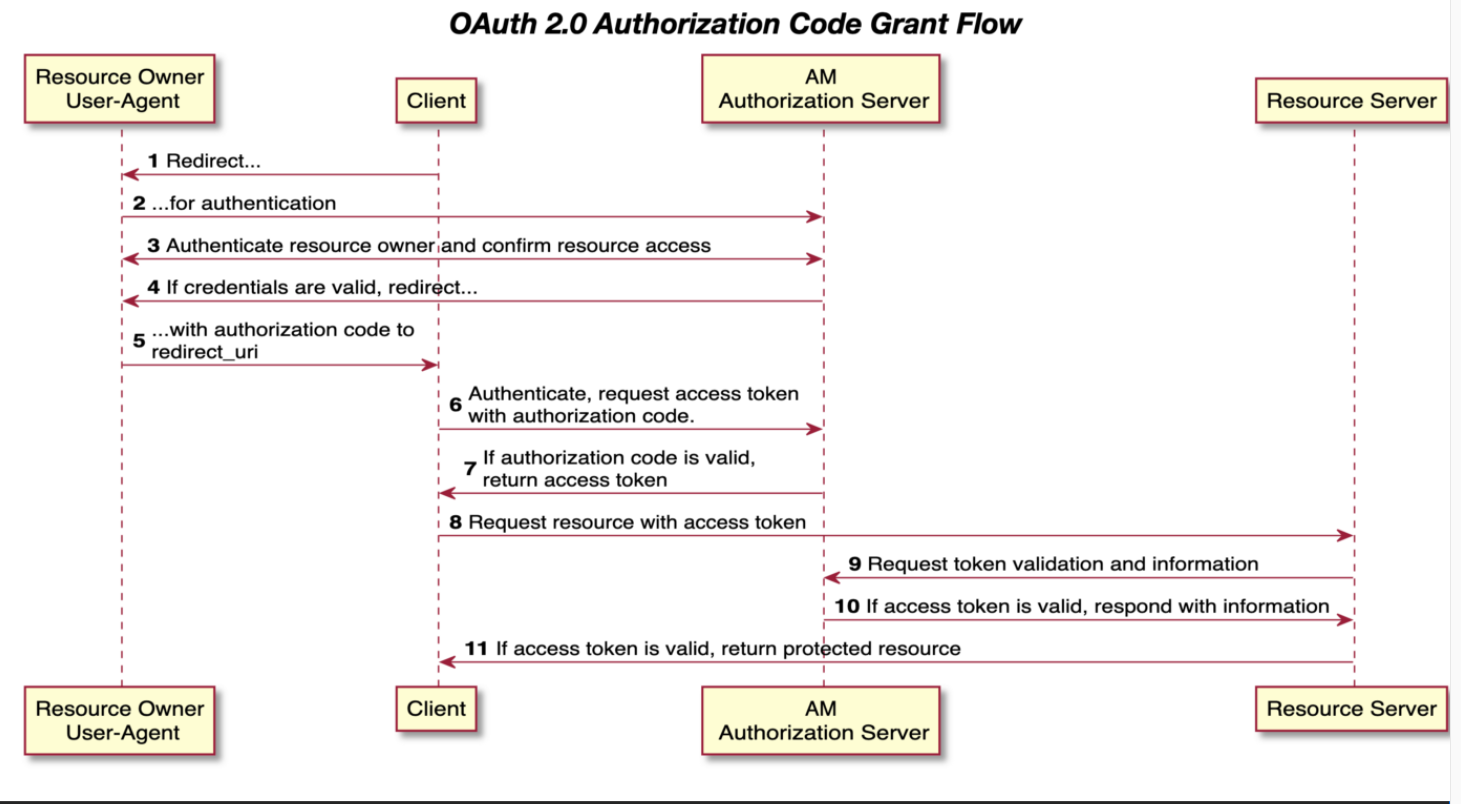

1. The client, usually a web-based service, receives a request to access a protected resource. To access the resources, the client requires authorization from the resource owner.

2. The client redirects the resource owner's user-agent to the authorization server.

3. The authorization server authenticates the resource owner, confirms resource access, and gathers consent if not previously saved.

4. The authorization server redirects the resource owner's user agent to the client.

5. During the redirection process, the authorization server appends an authorization code.

6. The client receives the authorization code and authenticates to the authorization server to exchange the code for an access token.

> Note that this example assumes a confidential client. Public clients are not required to authenticate.

7. If the authorization code is valid, the authorization server returns an access token (and a refresh token, if configured) to the client.

8. The client requests access to the protected resources from the resource server.

9. The resource server contacts the authorization server to validate the access token.

10. The authorization server validates the token and responds to the resource server.

11. If the token is valid, the resource server allows the client access to the protected resources.

> Reference for the above: https://backstage.forgerock.com/docs/am/6.5/oauth2-guide/#figure-oauth2-authz

Real World Example: Logging into DevNet Sandbox using Github

1. Resource owner (User) selects "Login using Github" when accessing the Client App (DevNet)
2. The Client App (DevNet) redirects the user browser to the Authorization server (GitHub)
3. The Authorization Server (Github) then asks the Resource owner to log in and asks the client to provide consent (ex. allow DevNet to access your Github email address)
4. The Authorization Server (Github) then redirects the browser back to the Client (DevNet) and provides an authorization code
5. The Client (DevNet) receives the authorization code and exchanges it with the Authorization Server (Github) for an access token
6. The Client (DevNet) then requests access to the Resource Server (DevNet Sandbox) with the access token
7. If access token is valid,  Resource Server (DevNet Sandbox) returns the requested resources